Para este notebook utilizaremos uma outra base de dados sobre aluguel de bicicletas.

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

mpl.rcParams['figure.figsize'] = (12,6)

# Configurando a fonte de forma global
mpl.rcParams['font.size'] = 14

SEED = 42

### Análise exploratória

In [62]:
df = pd.read_csv('bicicletas.csv')
df.head()

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datas        17414 non-null  object 
 1   contagem     17414 non-null  int64  
 2   temperatura  17414 non-null  float64
 3   sensacao     17414 non-null  float64
 4   umidade      17414 non-null  float64
 5   vel_vento    17414 non-null  float64
 6   clima        17414 non-null  float64
 7   feriado      17414 non-null  float64
 8   final_ds     17414 non-null  float64
 9   estacao      17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


Precisamos converter a coluna datas de object (string) para datetime.

In [64]:
df['datas'] = pd.to_datetime(df['datas'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datas        17414 non-null  datetime64[ns]
 1   contagem     17414 non-null  int64         
 2   temperatura  17414 non-null  float64       
 3   sensacao     17414 non-null  float64       
 4   umidade      17414 non-null  float64       
 5   vel_vento    17414 non-null  float64       
 6   clima        17414 non-null  float64       
 7   feriado      17414 non-null  float64       
 8   final_ds     17414 non-null  float64       
 9   estacao      17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

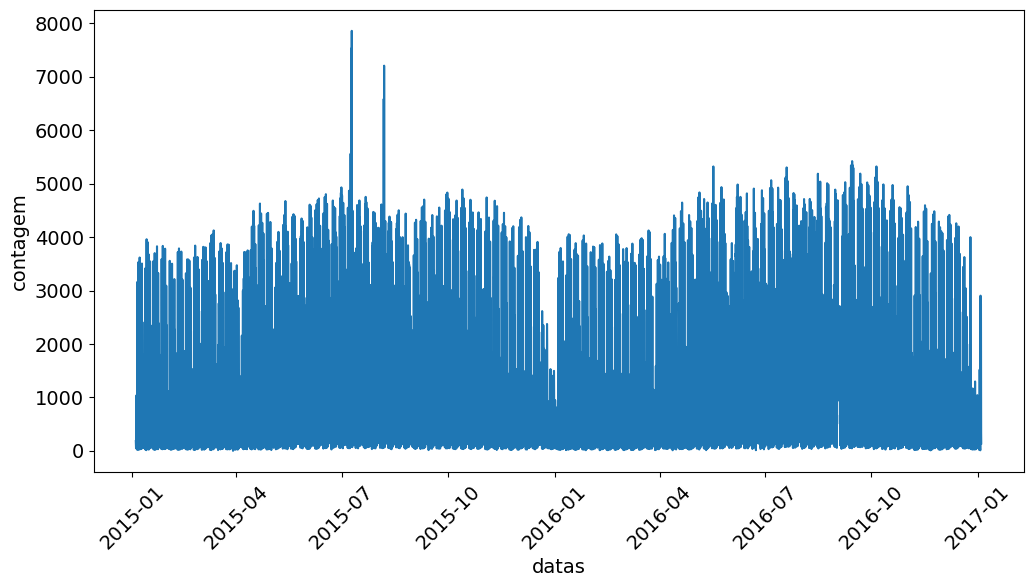

In [65]:
sns.lineplot(x='datas', y='contagem', data=df)
plt.xticks(rotation=45)

<Axes: ylabel='contagem'>

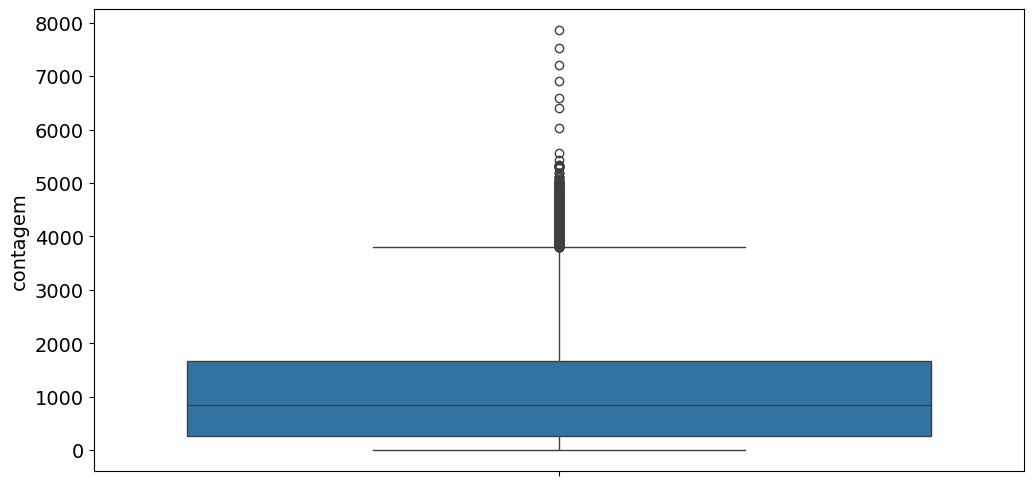

In [66]:
sns.boxplot(df['contagem'])

### Pré processamento

In [67]:
sc = StandardScaler()

# Necessário realizar o reshape pois o fit_transform espera que receba um array bi-dimensional
# O -1 serve para a função reshape inferir automaticamente a quantidade de linhas, porém esse array terá apenas uma coluna
y = sc.fit_transform(df['contagem'].values.reshape(-1,1))

# Seria a mesma coisa fazer da forma abaixo: linhas, colunas
df['contagem'].values.reshape(len(df['contagem'].values), 1)

array([[182],
       [138],
       [134],
       ...,
       [337],
       [224],
       [139]])

Separação do dado *contagem* entre treino e teste, aqui usaremos a mesma estratégia da preparação de dados de *séries temporais*.
- Iremos passar como dados de entrada e saída da rede neural o próprio retorno desejado (**contagem** de aluguel de bikes).

In [68]:
y_train, y_test = train_test_split(y, test_size=0.1, shuffle=False)

(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

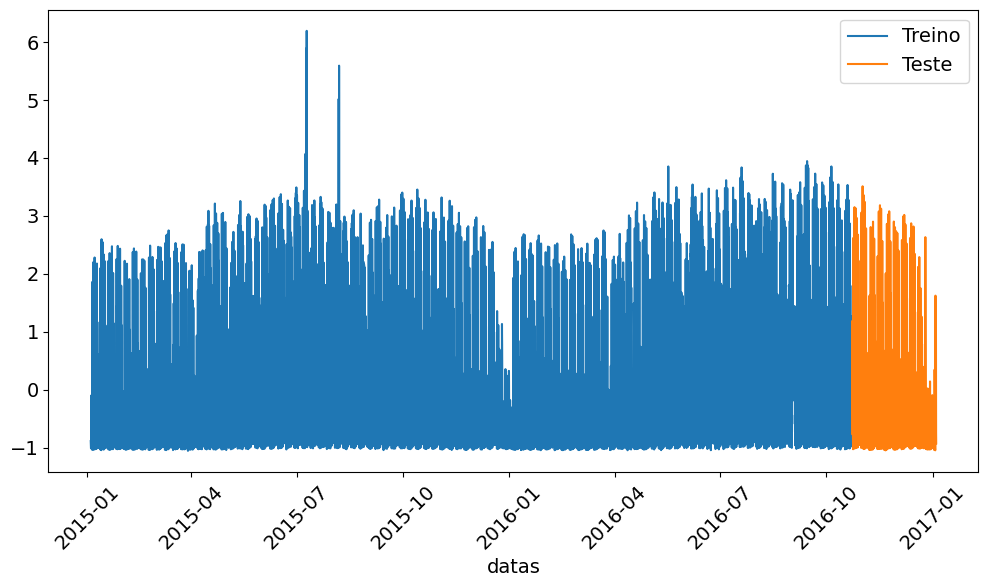

In [69]:
# Necessário fazer [:,0] pois o retorno de train_test_split é uma matriz, é necessário passar um vetor no x e y
sns.lineplot(x='datas', y=y_train[:,0], data=df[0:len(y_train)], label='Treino')
sns.lineplot(x='datas', y=y_test[:,0], data=df[len(y_train):len(y)], label='Teste')
plt.xticks(rotation=45)

Separação dos dados de séries temporais entre treino e teste usando a biblioteca *numpy*.

In [70]:
# Utilizando a biblioteca numpy para realizar a preparação dos dados de séries temporais

n_length = 10
y_train_array = y_train[:,0]

# Separação dos dados de treino
windows = sliding_window_view(y_train_array, window_shape=n_length +1)

X_train_time_series = windows[:, :-1]
y_train_time_series = windows[:, -1]


In [71]:
y_test_array = y_test[:,0]

# Separação dos dados de teste
windows = sliding_window_view(y_test_array, window_shape=n_length +1)

X_test_time_series = windows[:, :-1]
y_test_time_series = windows[:, -1]

### Redes Neurais (tradicionais)

São compostas por camadas de neurônios totalmente conectados. Esses neorônios transformam uma entrada (ou vetor de entradas) em uma sáida por meio de funções de ativação. Porém, elas têm uma limitação importante:
- Não conseguem lidar bem com dependências temporais ou sequenciais entre os dados. Cada entrada é processada como se fosse independente das anteriores.
- Exemplo: Uma rede tradicional pode classificar uma imagem analisando todos os pixels de uma vez, mas não consegue entender a sequência de palavras em uma frase.

### Redes Neurais Recorrentes

São um tipo de rede neural projetada para lidar com dados sequenciais ou temporais, como séries temporais, texto, áudio, vídeo, e outros tipos de dados onde a ordem ou dependência temporal entre os elementos é importante.

As RNNs (Redes Neurais Recorrentes) introduzem um conceito crucial: **memória**. Elas têm uma arquitetura que permite que a saída de uma célula da rede seja retroalimentada como entrada para a próxima célula, criando uma **conexão cíclica** (loop). Isso possibilita que a rede mantenha informações sobre entradas passadas e use esse contexto para prever ou classificar dados futuros.

**Estrutura básica de uma RNN**
- Cada unidade recorrente recebe duas entradas:
    - Entrada atual.
    - Estado oculto anterior (carrega informações de entradas anteriores).
    - Espera uma entrada de uma matriz tri-dimensional (dado de entrada atual, entradas anteriores, número de atributos por passo no tempo).

**Principais Diferenças:**

| Aspecto          | Rede Neural Tradicional       | Rede Neural Recorrente (RNN)       |
|-------------------|-------------------------------|------------------------------------|
| Tipo de Dados     | Dados independentes          | Dados sequenciais ou temporais    |
| Memória           | Não possui memória           | Possui memória de curto prazo     |
| Conexões          | Fluxo unidirecional (camada para camada) | Conexões cíclicas              |
| Aplicações        | Classificação de imagens, regressão | Texto, séries temporais, áudio, etc. |

### Preparando o modelo LSTM

Desta vez não utilizaremos mais para este caso camadas densas, e sim um tipo de algorítmo próprio para interpretar séries temporais (um algorítmo de rede recorrente).

**LSTM (Long Short-Term Memory)**

Um dos tipos de algoritmos de redes recorrentes que iremos utilizar é uma **LSTM (Long Short-Term Memory)**.
- Memória de longo e curto prazo.

Este inclui mecanismos para armazenar e esquecer informações de forma seletiva, utilizando gates (portões) como *input*, *gate*, *forget gate*, e *output gate*.

In [72]:
# Transformando em uma matriz (3 dimensões)                 linhas                      colunas             Quantidade de passos       
# Treino
X_train_time_series = X_train_time_series.reshape(X_train_time_series.shape[0], X_train_time_series.shape[1], 1)

# Teste
X_test_time_series = X_test_time_series.reshape(X_test_time_series.shape[0], X_train_time_series.shape[1], 1)

**Adicionando camada de entrada**

In [73]:
model_recurrent = keras.Sequential()
#            Terá 128 loops numa rede recorrente
#                                          input_shape recebe os 2 ultimos dimensões da matriz de entrada
#                                                              Colunas (1)              Quantidade de passos (1)
model_recurrent.add(keras.layers.LSTM(128, 
                                      input_shape=(X_train_time_series.shape[1], X_train_time_series.shape[2]),
                                      activation='tanh')) # Por padrão, a função de ativação é tanh (Tangente Hiperbólica)

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Camada de saída**

In [74]:
model_recurrent.add(keras.layers.Dense(units=1))

**Compilar a rede**

O **RMSProp (Root Mean Square Propagation)** é um otimizador amplamente usado em redes neurais, especialmente em situações em que os dados têm características dinâmicas, como séries temporais ou problemas que envolvem gradientes que variam de forma não uniforme. Pode resolver o problema de gradientes explosivos e gradientes muito pequenos.

**Como funciona o RMSProp?**

- Ajusta a taxa de aprendizado (*learning rate*) individualmente para cada peso da rede neural, adaptando-se às características dos dados e da arquitetura da rede.
- Com a normalização dos gradientes pela média móvel, o RMSProp **evita grandes oscilações durante o treinamento** (gradientes explodindo).
- Funciona bem em problemas que envolvem dependências sequencias, como Redes Neurais Recorrentes (RNNs).

Foi escolhido este otimizador dos pesos no treinamento da rede neural com o objetivo de utilizar um otimizador **adaptativo**. Este tipo de otimizador é capaz de controlar o gradiente e vitar que este cresça ou diminua muito.

Tanto o **Adam** quanto o **RMSProp são adaptativos** e seriam boas escolhas para a solução do problema.

Outros otimizadores:
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [75]:
model_recurrent.compile(loss=keras.losses.MeanSquaredError(),
                        optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                        metrics=[keras.metrics.R2Score(), keras.metrics.MeanSquaredError()])

In [76]:
model_recurrent.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss'),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='best_model_recurrent_LSTM.keras',
                                             save_best_only=True)]

history = model_recurrent.fit(X_train_time_series, y_train_time_series,
                    validation_data=(X_test_time_series, y_test_time_series),
                    callbacks=callbacks,
                    epochs=10)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4815 - mean_squared_error: 0.4815 - r2_score: 0.5144 - val_loss: 0.0992 - val_mean_squared_error: 0.0992 - val_r2_score: 0.8644
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0967 - mean_squared_error: 0.0967 - r2_score: 0.9046 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_r2_score: 0.9326
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - r2_score: 0.9437 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_r2_score: 0.9450
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - r2_score: 0.9498 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_r2_score: 0.9570
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - r2_score: 0.9601 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_r2_score: 0.9444
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

### Avaliando o modelo LSTM

**Visualizando a métrica r2_score por época**

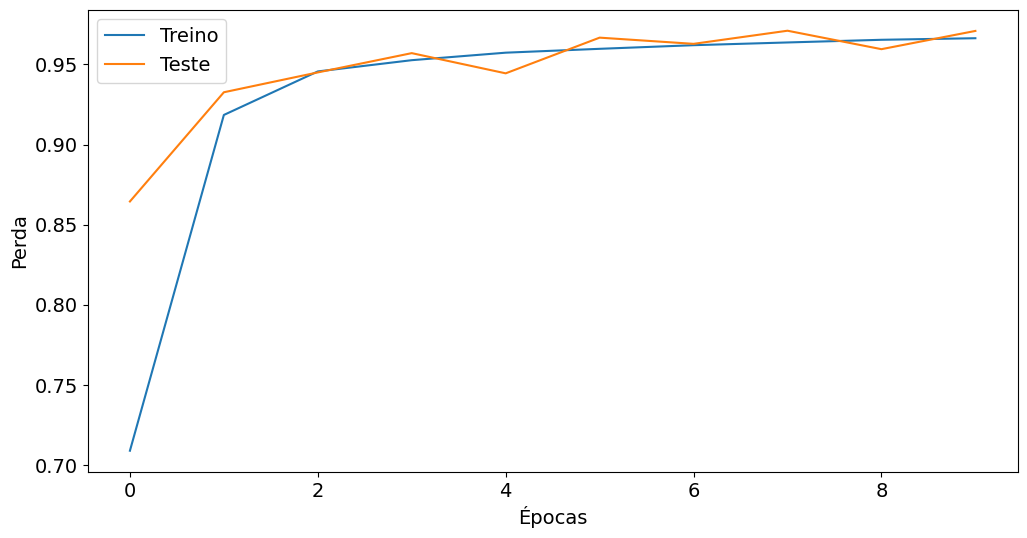

In [78]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Teste'])

**Visualizando perda nos dados de treino e teste**

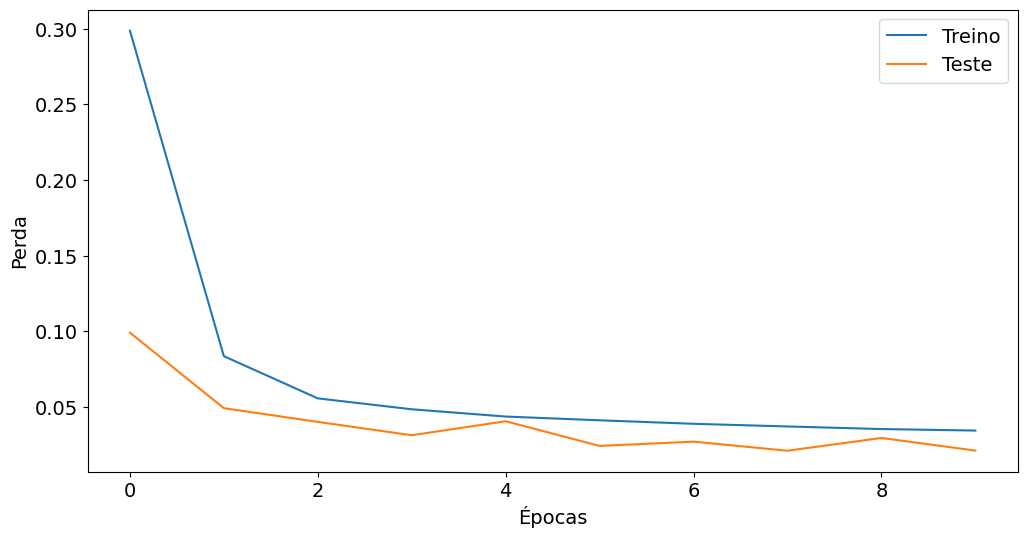

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Teste'])

Realizando a "Previsão" dos dados de treino para criar o gráfico e verificar o quanto os dados de treino se ajustaram ao dados reais.

In [80]:
y_train_adjusted = model_recurrent.predict(X_train_time_series)

490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [81]:
y_test_predicts = model_recurrent.predict(X_test_time_series)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Visualização dos valores esperados e os dados de treino ajustados.

<Axes: xlabel='datas'>

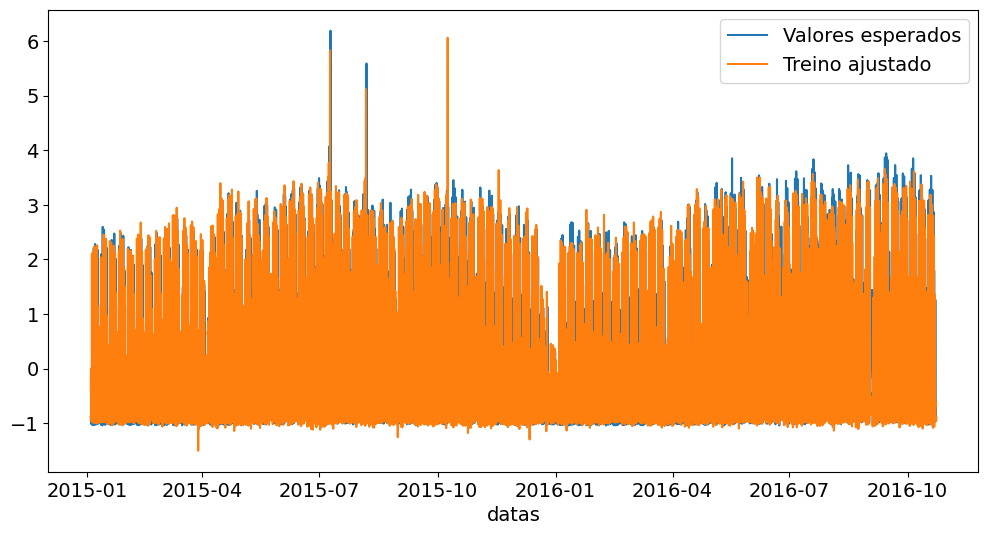

In [82]:
# Exibindo dados reais x valores de treino ajustados
sns.lineplot(x='datas', y=y_train[:,0], data=df[0:len(y_train)], label='Valores esperados')
sns.lineplot(x='datas', y=y_train_adjusted[:,0], data=df[0:len(y_train_adjusted)], label='Treino ajustado')

Visualização dos dados de teste

Na segunda linha do *lineplot* é necessário **somar a quantidade de passos com a quantidade de dados de treinamento** pois, ao trabalhar com séries temporais e utilizar uma abordagem baseada em janelas deslizantes (*sliding_window_view*), é esperado que a divisão dos dados em janelas cause uma **redução no número total de amostras**.

Isso acontece porque cada janela necessita de um número fixo de valores consecutivos (definido pelo window_shape) e **descarta os valores iniciais (no caso, 10)** que não podem formar uma janela completa.

<Axes: xlabel='datas'>

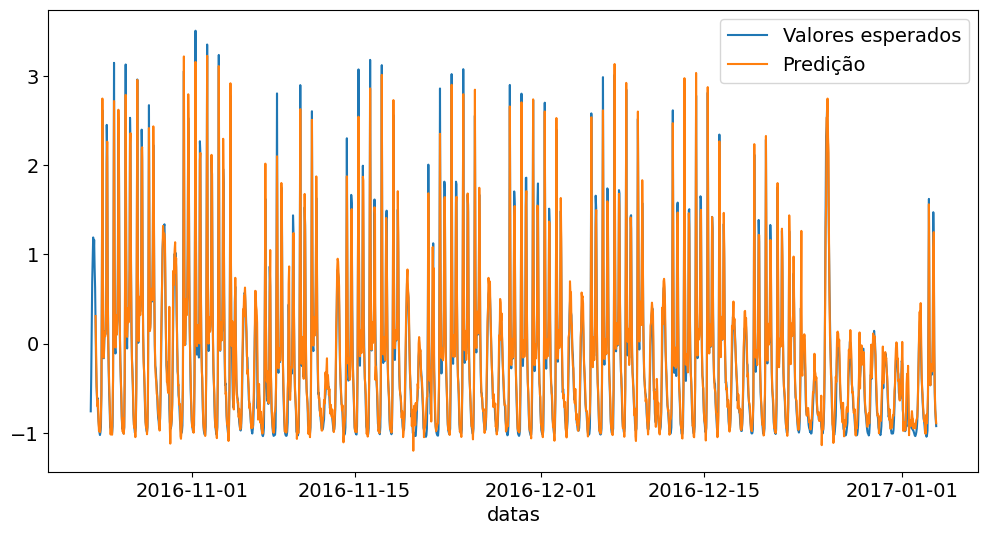

In [83]:
# Exibindo dados reais x dados previstos (inferidos, predição)
sns.lineplot(x='datas', y=y_test[:,0], data=df[len(y_train):len(df)], label='Valores esperados')
sns.lineplot(x='datas', y=y_test_predicts[:,0], data=df[len(y_train) + n_length:len(df)], label='Predição')

### Preparando o modelo GRU

**GRU (Gated Recurrent Unit)**

Também temos o **GRU (Gated Recurrent Unit)**, similar ao LSTM, mas com uma arquitetura mais simples e menos parâmetros.
- Treinamento mais rápido.
- Menos parâmetros para treinar.
- Porém, as LSTMs conseguem "lembrar" de sequências maiores, sendo assim, o GRU é recomendado para sequências menores (quando temos menos dados) e LSTMs quando temos sequências maiores (quando temos mais dados).

Criando o modelo

In [84]:
model_recurrent_GRU = keras.Sequential()

# Camada de entrada
model_recurrent_GRU.add(keras.layers.GRU(128,
                                         input_shape=(X_train_time_series.shape[1], X_train_time_series.shape[2]),
                                         activation='tanh'))

# Camada de saída
model_recurrent_GRU.add(keras.layers.Dense(1))

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilando o modelo

In [85]:
model_recurrent_GRU.compile(loss=keras.losses.MeanSquaredError(),
                        optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                        metrics=[keras.metrics.R2Score(), keras.metrics.MeanSquaredError()])

In [86]:
model_recurrent_GRU.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,433 (197.00 KB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando o modelo

In [87]:
callbacks = [keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='best_model_recurrent_GRU.keras',
                                             save_best_only=True)]

history = model_recurrent_GRU.fit(X_train_time_series, y_train_time_series,
                                  validation_data=(X_test_time_series, y_test_time_series),
                                  callbacks=callbacks, # Utilizando o mesmo callback criado anteriormente
                                  epochs=10)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4145 - mean_squared_error: 0.4145 - r2_score: 0.5985 - val_loss: 0.0699 - val_mean_squared_error: 0.0699 - val_r2_score: 0.9046
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0783 - mean_squared_error: 0.0783 - r2_score: 0.9225 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_r2_score: 0.9362
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - r2_score: 0.9454 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_r2_score: 0.9543
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - r2_score: 0.9510 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_r2_score: 0.9661
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - r2_score: 0.9557 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_r2_score: 0.9635
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

### Avaliando o modelo GRU

**Visualizando a métrica r2_score por época**

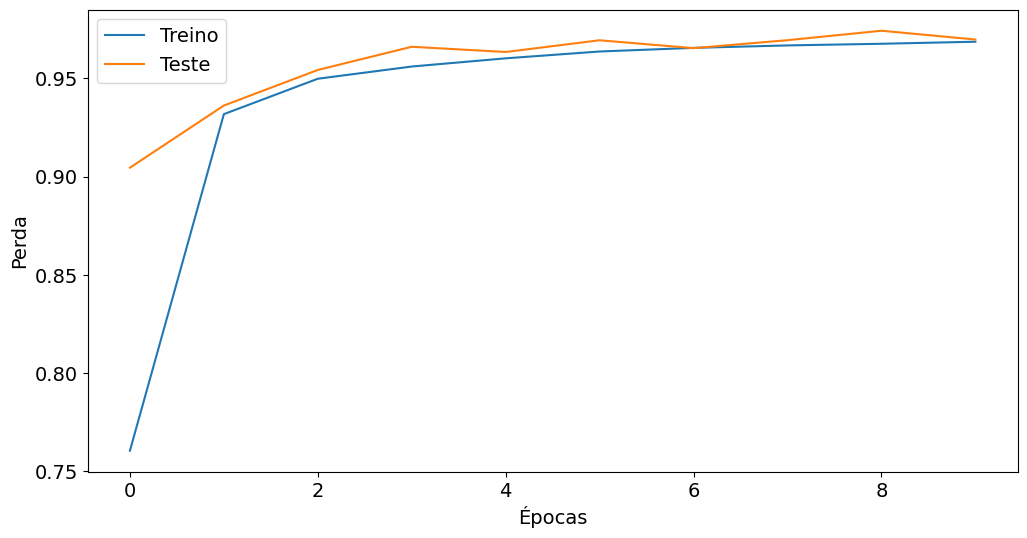

In [88]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Teste'])

**Visualizando o valor de perda por época**

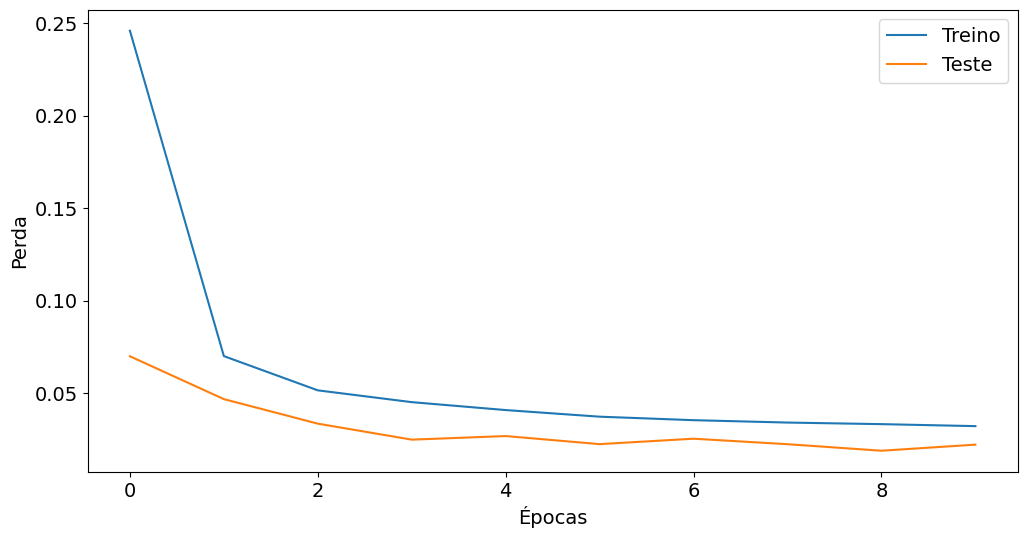

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Teste'])

<Axes: xlabel='datas'>

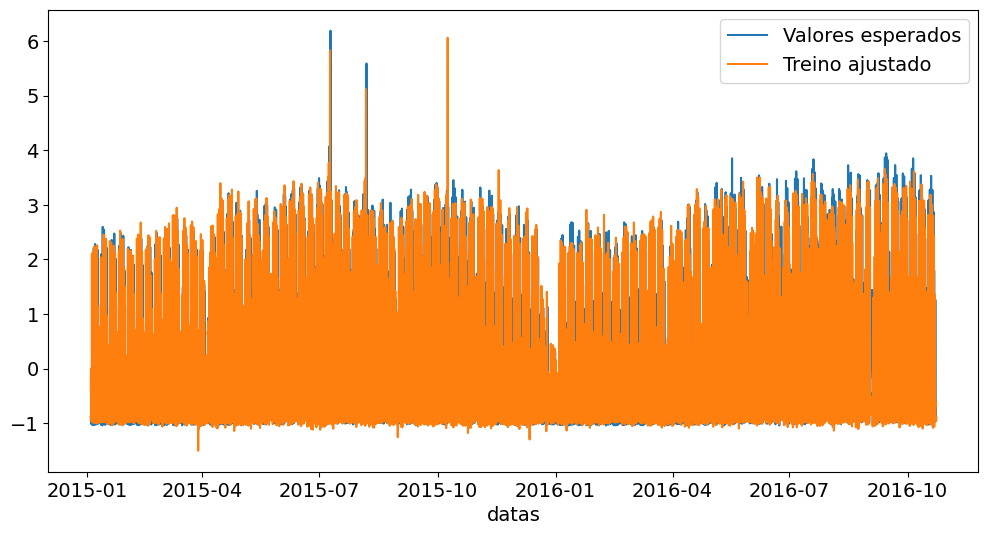

In [90]:
# Exibindo dados reais x valores de treino ajustados
sns.lineplot(x='datas', y=y_train[:,0], data=df[0:len(y_train)], label='Valores esperados')
sns.lineplot(x='datas', y=y_train_adjusted[:,0], data=df[0:len(y_train_adjusted)], label='Treino ajustado')

<Axes: xlabel='datas'>

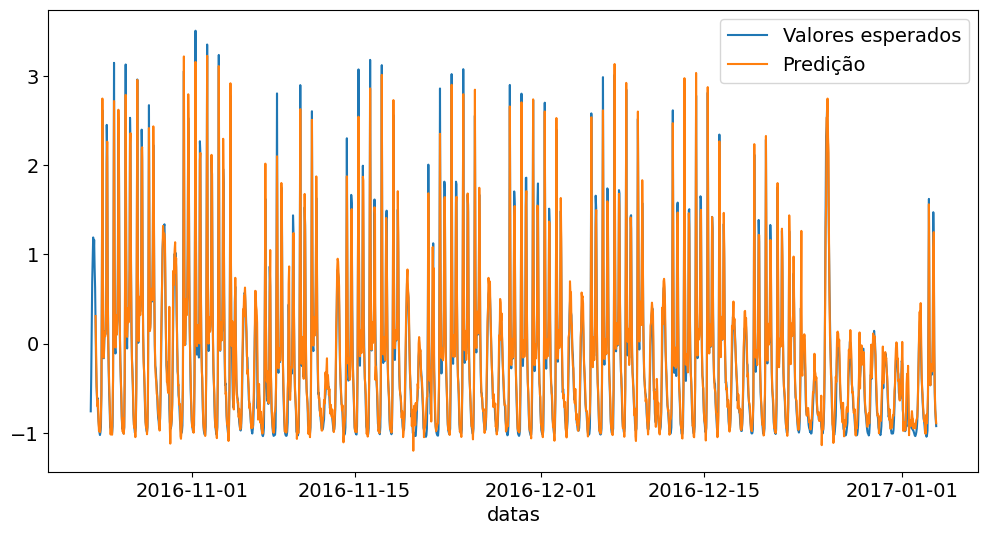

In [91]:
# Exibindo dados reais x dados previstos (inferidos, predição)
sns.lineplot(x='datas', y=y_test[:,0], data=df[len(y_train):len(df)], label='Valores esperados')
sns.lineplot(x='datas', y=y_test_predicts[:,0], data=df[len(y_train) + n_length:len(df)], label='Predição')